In [1]:
import pandas as pd
import numpy as np
from scipy import integrate
from ahrs.filters import EKF
from ahrs.common.orientation import acc2q

# Load data
df = pd.read_csv('416Hz_BOT.csv')

# Convert data to numpy arrays
accelerometer = df[['AccelerometerX', 'AccelerometerY', 'AccelerometerZ']].to_numpy()
gyroscope = df[['GyroscopeX', 'GyroscopeY', 'GyroscopeZ']].to_numpy()
timestamp = df['Timestamp'].to_numpy()

In [2]:
import pandas as pd
import numpy as np



In [3]:
from ahrs.filters import EKF
from ahrs.common.orientation import acc2q

# Initial guess
Q_init = acc2q(accelerometer[0])

# Initialize EKF
ekf = EKF(Q_init)

# For storing the orientations
orientations = np.zeros((len(accelerometer), 4))

# The first orientation is our initial guess
orientations[0] = Q_init

for i in range(1, len(accelerometer)):
    orientations[i] = ekf.update(q=orientations[i-1], acc=accelerometer[i], gyr=gyroscope[i])
    #print(orientations[i])
# Now 'orientations' contains the orientations at each timestamp


In [7]:
from ahrs.common import Quaternion

# Convert quaternions to rotation matrices
rotation_matrices = np.array([Quaternion(q).to_DCM() for q in orientations])

# Correct accelerometer data for the effects of gravity
gravity = np.array([0, 0, -9.81])  # assuming Z-axis is up
corrected_acceleration = np.empty_like(accelerometer)

for i in range(len(timestamp)):
    corrected_acceleration[i] = rotation_matrices[i].dot(accelerometer[i]) - gravity

# Double integrate acceleration to get displacement
# Initialize arrays for velocity and displacement
velocity = np.zeros_like(corrected_acceleration)
displacement = np.zeros_like(corrected_acceleration)

# Calculate time intervals if they are not uniform
dt = np.diff(timestamp)
dt = np.insert(dt, 0, dt[0])  # duplicate first delta time

# Double integrate using the corrected acceleration
for i in range(1, len(timestamp)):
    velocity[i] = velocity[i-1] + corrected_acceleration[i] * dt[i]
    displacement[i] = displacement[i-1] + velocity[i] * dt[i]

# Now 'displacement' contains the displacement at each timestamp
print(displacement)


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 7.66720282e-06  9.05480325e-06  7.53998737e-04]
 [ 3.14713489e-05  3.88205161e-05  2.26191471e-03]
 ...
 [ 7.42855472e+06  8.88905388e+06 -1.25131818e+10]
 [ 7.42856018e+06  8.88905565e+06 -1.25131853e+10]
 [ 7.42856563e+06  8.88905742e+06 -1.25131888e+10]]


C:\Users\shoai\AppData\Local\Temp\ipykernel_19188\1381628263.py:16: UserWarning: Attempting to set identical low and high zlims makes transformation singular; automatically expanding.
  ax.set_zlim([100,100])  # Z-axis limits


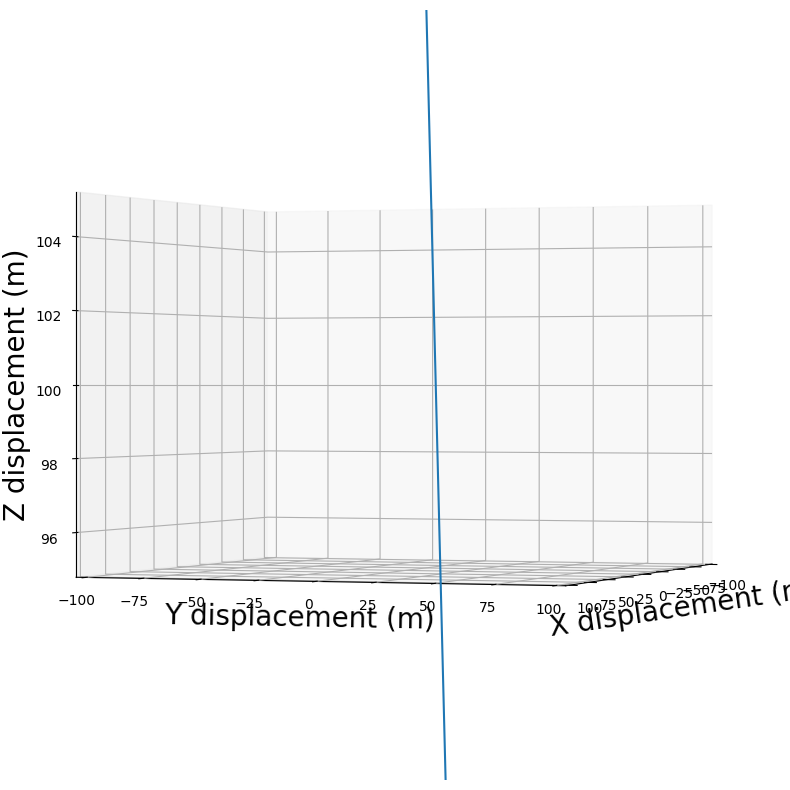

In [9]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(displacement[:, 0], displacement[:, 1], displacement[:, 2])
ax.set_xlabel('X displacement (m)')
ax.set_ylabel('Y displacement (m)')
ax.set_zlabel('Z displacement (m)')

# Set the limits of the axes
x = 100
ax.set_xlim([-x, x])  # X-axis limits
ax.set_ylim([-x, x])  # Y-axis limits
ax.set_zlim([100,100])  # Z-axis limits

# Adjust the viewing angle
ax.view_init(elev=0, azim=20)

# Increase label font size for better visibility
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.zaxis.label.set_size(20)

plt.show()


In [4]:
from scipy import signal

def high_pass_filter(data, cutoff_frequency, sample_frequency):
    nyquist_frequency = 0.5 * sample_frequency
    normalized_cutoff_frequency = cutoff_frequency / nyquist_frequency
    b, a = signal.butter(5, normalized_cutoff_frequency, btype='high')
    return signal.filtfilt(b, a, data)

def low_pass_filter(data, cutoff_frequency, sample_frequency):
    nyquist_frequency = 0.5 * sample_frequency
    normalized_cutoff_frequency = cutoff_frequency / nyquist_frequency
    b, a = signal.butter(5, normalized_cutoff_frequency, btype='low')
    return signal.filtfilt(b, a, data)


In [5]:
cutoff_frequency_high = 0.1  # example value, adjust as needed
cutoff_frequency_low = 5.0  # example value, adjust as needed
sample_frequency = 416  # your data's sample frequency

filtered_accelerometer = high_pass_filter(accelerometer, cutoff_frequency_high, sample_frequency)
filtered_accelerometer = low_pass_filter(filtered_accelerometer, cutoff_frequency_low, sample_frequency)


ValueError: The length of the input vector x must be greater than padlen, which is 18.

In [ ]:
# Integration to get velocity
velocity = np.cumsum(filtered_accelerometer, axis=0) / sample_frequency
velocity -= np.mean(velocity, axis=0)  # subtract mean to eliminate drift

# Integration to get displacement
displacement = np.cumsum(velocity, axis=0) / sample_frequency
displacement -= np.mean(displacement, axis=0)  # subtract mean to eliminate drift


In [ ]:
from scipy.integrate import cumtrapz
from ahrs.common import DEG2RAD

# Subtract gravity from accelerometer data
gravity = np.array([0, 0, -9.81])  # assuming z-axis is up and in m/s^2
accel_no_gravity = accelerometer - gravity

# Rotate accelerometer data into the Earth frame
accel_earth = np.empty_like(accel_no_gravity)
for i in range(len(accel_no_gravity)):
    accel_earth[i] = ekf.Q_mat(orientations[i]).dot(accel_no_gravity[i])

# Double integrate acceleration to get displacement
velocity = cumtrapz(accel_earth, dx=1.0/416.0, axis=0, initial=0)
displacement = cumtrapz(velocity, dx=1.0/416.0, axis=0, initial=0)


In [8]:
sample_rate = 416  # Hz
dt = 1.0 / sample_rate

# Initialize AHRS algorithm
ahrs = Madgwick()

'''Quaternion Estimation with IMU architecture.

Parameters:	
q (numpy.ndarray) – A-priori quaternion.
gyr (numpy.ndarray) – Sample of tri-axial Gyroscope in rad/s
acc (numpy.ndarray) – Sample of tri-axial Accelerometer in m/s^2
dt (float, default: None) – Time step, in seconds, between consecutive Quaternions.
Returns:	
q – Estimated quaternion.

Return type:	
numpy.ndarray'''


# Process sensor data

quaternions = np.zeros((len(timestamp), 4))
quaternions[0] = [1, 0, 0, 0]  # initial quaternion

# Process sensor data
for i in range(1, len(timestamp)):
    quaternions[i] = ahrs.updateIMU(q=quaternions[i-1], gyr=gyroscope[i], acc=accelerometer[i])


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.46495207e-05 -5.18921317e-05  8.06965355e-04]
 [-1.05140221e-04 -1.57072968e-04  2.42132629e-03]
 ...
 [-9.09687436e+04  5.83462927e+05  1.97309957e+10]
 [-9.09687925e+04  5.83463117e+05  1.97310014e+10]
 [-9.09688415e+04  5.83463306e+05  1.97310071e+10]]


'\n In particular, the accelerometer data is likely to be noisy, and the double integration can amplify this noise and lead to large errors in \n the calculated displacement. You may need to apply some form of noise filtering or smoothing to the accelerometer data before integrating it. \n Also, the removal of gravity assumes that the Z-axis is up and that the device is not accelerating vertically, which may not be true in all cases\n\n'

In [45]:
print(velocity)

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-1.44142006e-02 -2.15871268e-02  3.35697588e-01]
 [-2.93241311e-02 -4.37552279e-02  6.71574150e-01]
 ...
 [-2.03637090e+01  7.87823996e+01  2.35396964e+06]
 [-2.03633970e+01  7.87814375e+01  2.35396998e+06]
 [-2.03639592e+01  7.87811739e+01  2.35397031e+06]]


In [44]:
print(corrected_acceleration)

[[-6.37803444e+00 -9.33478462e+00  1.39728946e+02]
 [-5.99630745e+00 -8.98024474e+00  1.39650196e+02]
 [-6.20253111e+00 -9.22193007e+00  1.39724650e+02]
 ...
 [-1.71330769e-02 -1.24240663e-01  1.40816601e+02]
 [ 1.29792059e-01 -4.00229831e-01  1.40832708e+02]
 [-2.33867174e-01 -1.09677752e-01  1.40818341e+02]]


In [43]:
# Print displacement
print(displacement)


[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-3.46495207e-05 -5.18921317e-05  8.06965355e-04]
 [-1.05140221e-04 -1.57072968e-04  2.42132629e-03]
 ...
 [-9.09687436e+04  5.83462927e+05  1.97309957e+10]
 [-9.09687925e+04  5.83463117e+05  1.97310014e+10]
 [-9.09688415e+04  5.83463306e+05  1.97310071e+10]]


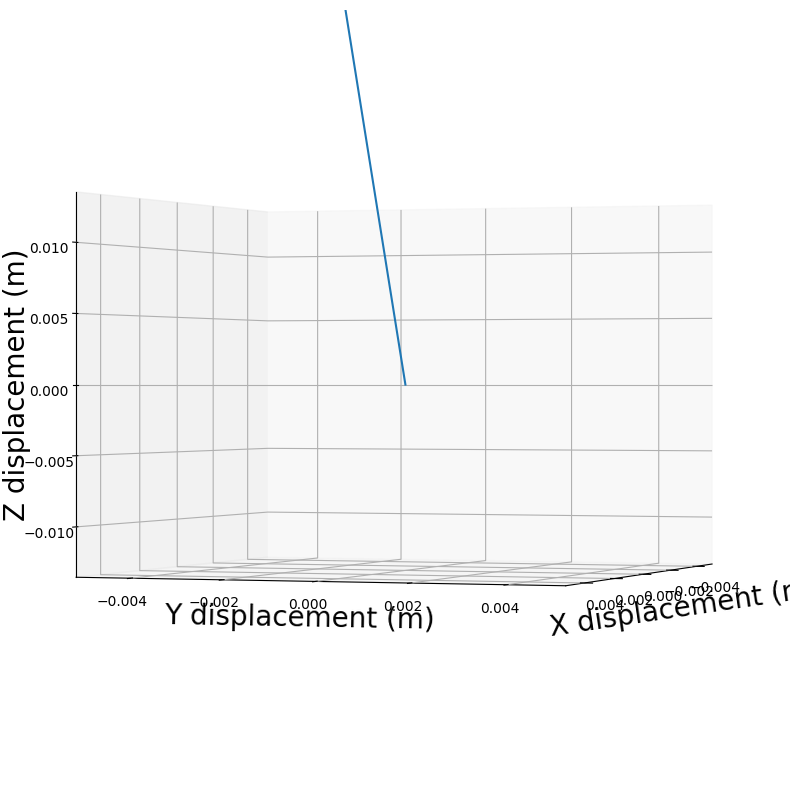

In [41]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(displacement[:, 0], displacement[:, 1], displacement[:, 2])
ax.set_xlabel('X displacement (m)')
ax.set_ylabel('Y displacement (m)')
ax.set_zlabel('Z displacement (m)')

# Set the limits of the axes
x = 0.005
ax.set_xlim([-x, x])  # X-axis limits
ax.set_ylim([-x, x])  # Y-axis limits
ax.set_zlim([-0.013, 0.013])  # Z-axis limits

# Adjust the viewing angle
ax.view_init(elev=0, azim=20)

# Increase label font size for better visibility
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.zaxis.label.set_size(20)

plt.show()


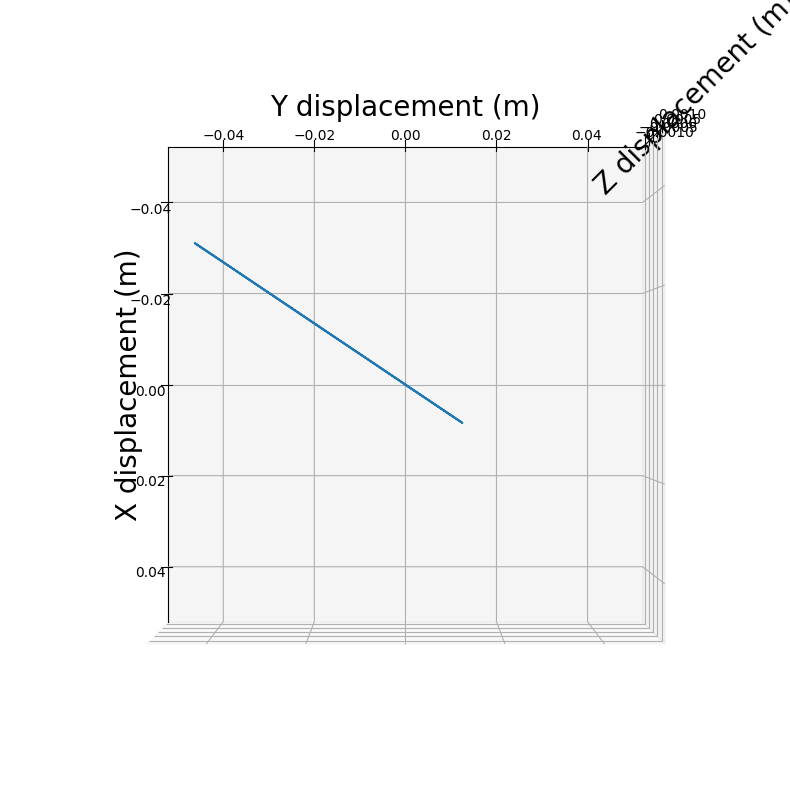

In [42]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(displacement[:, 0], displacement[:, 1], displacement[:, 2])
ax.set_xlabel('X displacement (m)')
ax.set_ylabel('Y displacement (m)')
ax.set_zlabel('Z displacement (m)')

# Set the limits of the axes
x = 0.05
ax.set_xlim([-x, x])  # X-axis limits
ax.set_ylim([-x, x])  # Y-axis limits
ax.set_zlim([-0.0013, 0.0013])  # Z-axis limits

# Adjust the viewing angle
ax.view_init(elev=90, azim=0)

# Increase label font size for better visibility
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.zaxis.label.set_size(20)

plt.show()


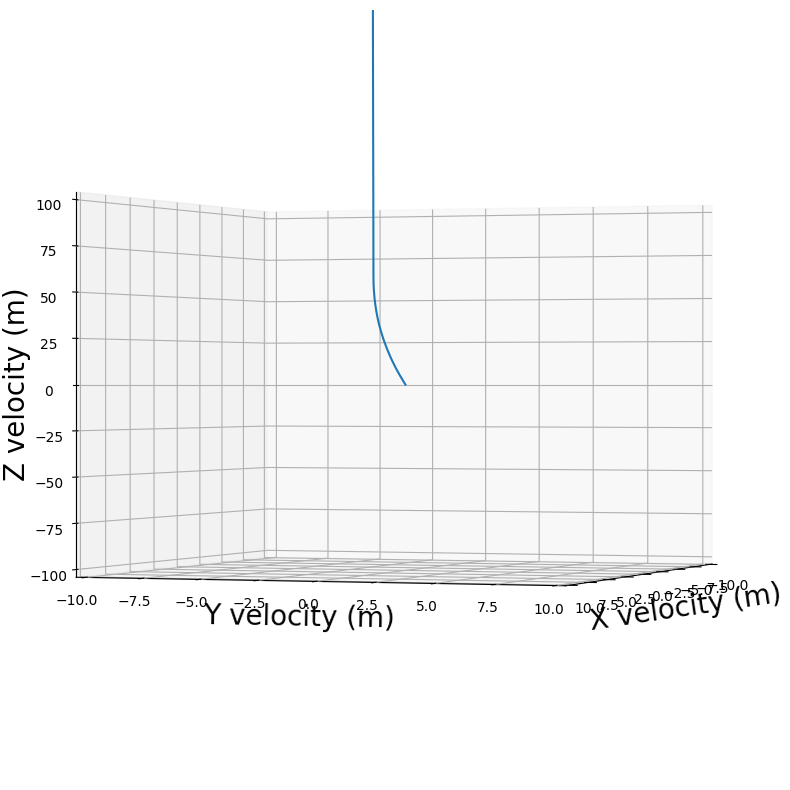

In [26]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(velocity[:, 0], velocity[:, 1], velocity[:, 2])
ax.set_xlabel('X velocity (m)')
ax.set_ylabel('Y velocity (m)')
ax.set_zlabel('Z velocity (m)')

# Set the limits of the axes
x = 10
ax.set_xlim([-x, x])  # X-axis limits
ax.set_ylim([-x, x])  # Y-axis limits
ax.set_zlim([-100, 100])  # Z-axis limits

# Adjust the viewing angle
ax.view_init(elev=0, azim=20)

# Increase label font size for better visibility
ax.xaxis.label.set_size(20)
ax.yaxis.label.set_size(20)
ax.zaxis.label.set_size(20)

plt.show()